In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *
from ReadData import *
from GetJSON import get

In [3]:
def PlotMats(mats, titles):
    fig, axs = plt.subplots(1, len(mats), figsize=(6 * len(mats), 4))
    for i in range(len(mats)):
        mat = mats[i]
        title = titles[i]
        sns.distplot(mat[~np.isnan(mat)].flatten(), kde=False, axlabel='Normalized Expression Value', ax=axs[i]).set_title(title)
    fig.suptitle('Histogram of counts for each dataset')

In [4]:
baseDFDir = get('folders.processed')
actDF = GetDataFrame(baseDFDir + 'ACT.tsv').set_index('PCG')
actDF.columns = actDF.columns.astype(float).astype(int)
actMat = actDF.values

In [5]:
msbbDF = GetDataFrame(baseDFDir + 'MSBB_RNA.tsv').set_index('PCG')
msbbDF.columns = msbbDF.columns.astype(float).astype(int)
msbbMat = msbbDF.values

In [6]:
rosmapDF = GetDataFrame(baseDFDir + 'ROSMAP_GE1.tsv').set_index('PCG')
rosmapDF.columns = rosmapDF.columns.astype(float).astype(int)
rosmapMat = rosmapDF.values

In [7]:
dataDF = JoinMultipleGenes(actDF, msbbDF, rosmapDF)

/homes/gws/psturm/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


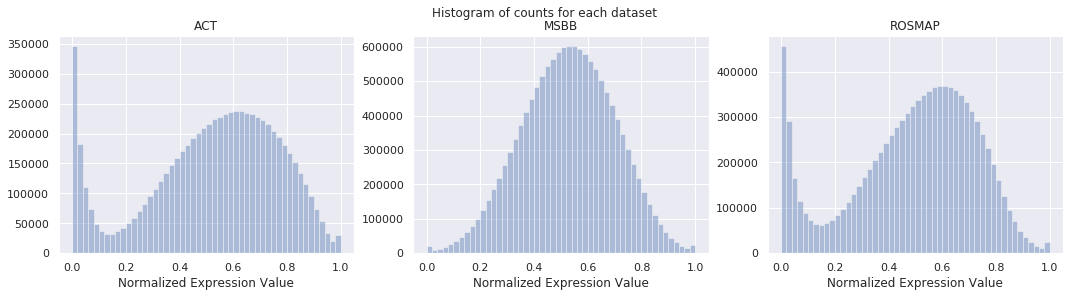

In [8]:
PlotMats([actMat, msbbMat, rosmapMat], titles=['ACT', 'MSBB', 'ROSMAP'])

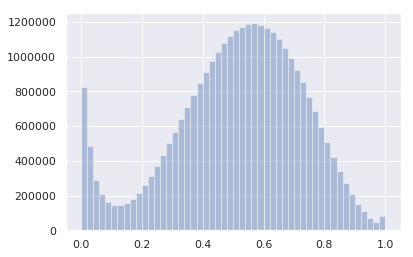

In [9]:
sns.distplot(dataDF.values[~np.isnan(dataDF.values)].flatten(), kde=False)

In [10]:
phenoBaseDir = get('folders.phenotypes')

In [73]:
def normalizePhenotypes(df, phenotypes):
    for phenotype in phenotypes:
        df[phenotype] = df[phenotype] / np.max(df[phenotype])
    return df

In [81]:
actPhenoDF = GetDataFrame(phenoBaseDir + 'ACT.tsv')
msbbPhenoDF = GetDataFrame(phenoBaseDir + 'MSBB_RNA.tsv')
rosmapPhenoDF = GetDataFrame(phenoBaseDir + 'ROSMAP_GE1.tsv')

actPhenoDF  = actPhenoDF[['sample_name', 'BRAAK', 'CERAD', 'ABETA_IHC', 'TAU_IHC']] #Figure out which phenotypes to keep
msbbPhenoDF = msbbPhenoDF[['sample_name', 'BRAAK', 'CERAD', 'PLAQUES']]
rosmapPhenoDF = rosmapPhenoDF[['sample_name', 'BRAAK', 'CERAD', 'PLAQUES', 'ABETA_IHC', 'TAU_IHC']]

actPhenoDF = normalizePhenotypes(actPhenoDF, ['BRAAK', 'CERAD', 'ABETA_IHC', 'TAU_IHC'])
msbbPhenoDF = normalizePhenotypes(msbbPhenoDF, ['BRAAK', 'CERAD', 'PLAQUES'])
rosmapPhenoDF = normalizePhenotypes(rosmapPhenoDF, ['BRAAK', 'CERAD', 'PLAQUES', 'ABETA_IHC', 'TAU_IHC'])

rosmapPhenoDF = rosmapPhenoDF[~rosmapPhenoDF['sample_name'].duplicated(keep='first')]

actPhenoDF['sample_name'] = actPhenoDF['sample_name'].astype(int)
msbbPhenoDF['sample_name'] = msbbPhenoDF['sample_name'].astype(int)
rosmapPhenoDF['sample_name'] = rosmapPhenoDF['sample_name'].astype(int)
phenotypes = ['BRAAK', 'CERAD', 'PLAQUES', 'ABETA_IHC', 'TAU_IHC']

In [82]:
actPhenoDF.head()

,sample_name,BRAAK,CERAD,ABETA_IHC,TAU_IHC
0,488395315,0.500000,1.000000,0.466675,0.096909
1,496100277,0.500000,0.333333,0.038185,0.002176
2,496100278,1.000000,0.000000,0.004278,0.000532
3,496100279,1.000000,0.000000,0.010662,0.000806
4,496100281,0.166667,0.000000,0.033745,0.510205


In [83]:
msbbPhenoDF.head()

,sample_name,BRAAK,CERAD,PLAQUES
0,16955,0.500000,1.000000,0.333333
1,16365,0.833333,0.000000,0.050238
2,17155,0.833333,1.000000,0.396190
3,17135,0.833333,1.000000,0.395238
4,16625,0.666667,0.666667,0.146190


In [84]:
rosmapPhenoDF.head()

,sample_name,BRAAK,CERAD,PLAQUES,ABETA_IHC,TAU_IHC
0,5251205150,0.333333,0.0,0.000000,0.100532,0.000000
1,3831205030,0.833333,1.0,0.190075,0.020715,0.022382
2,931204170,0.000000,0.0,0.000000,0.000000,0.000000
3,6101205230,0.333333,0.0,0.000000,0.000000,0.000110
4,5601205170,0.833333,1.0,0.259597,0.301026,0.021988


In [85]:
actCombDF    = JoinGenePheno(actDF, actPhenoDF)
msbbCombDF   = JoinGenePheno(msbbDF, msbbPhenoDF) 
rosmapCombDF = JoinGenePheno(rosmapDF, rosmapPhenoDF)

In [86]:
actCombDF.tail()

,488395315,496100277,496100278,496100279,496100281,496100283,496100284,496100285,496100287,496100288,...,496100661,496100663,496100664,496100665,496100666,496100667,496100669,496100670,496100671,496100672
PCG,,,,,,,,,,,,,,,,,,,,,
ABCA8,0.780794,0.996289,0.901538,0.643716,0.572571,0.597095,0.610090,0.624553,0.626432,0.675944,...,0.616697,0.578617,0.676251,0.578559,0.663325,0.589669,0.777911,0.549474,0.617015,0.898324
BRAAK,0.500000,0.500000,1.000000,1.000000,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,...,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CERAD,1.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.666667,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABETA_IHC,0.466675,0.038185,0.004278,0.010662,0.033745,0.040946,0.010449,0.355101,0.132327,0.035876,...,0.104883,0.076124,0.063732,0.638452,0.045924,0.102361,0.004892,0.578109,0.031196,0.130016
TAU_IHC,0.096909,0.002176,0.000532,0.000806,0.510205,0.001087,0.001712,0.001887,0.012920,0.120113,...,0.000675,0.000368,0.312138,0.798016,0.193904,0.000482,0.000845,0.839203,0.106278,0.043493


In [87]:
msbbCombDF.tail()

,16955,16365,17155,17135,16625,16295,17045,16635,4301,16495,...,649,648,647,683,681,682,13081,12464,787,153
PCG,,,,,,,,,,,,,,,,,,,,,
ITIH2,0.439141,0.497639,0.583276,0.518614,0.526602,0.573178,0.450042,0.673029,0.557926,0.586690,...,0.599957,0.571297,0.662064,0.302293,0.443306,0.540783,0.406036,0.598087,0.615691,0.459373
ABCA8,0.839478,0.639237,0.812641,0.627547,0.706042,0.549022,0.693144,0.702683,0.613688,0.639924,...,0.536228,0.464380,0.510440,0.255308,0.576825,0.442273,0.290181,0.343539,0.724093,0.498192
BRAAK,0.500000,0.833333,0.833333,0.833333,0.666667,NaN,NaN,NaN,NaN,NaN,...,0.333333,0.666667,0.500000,0.333333,0.833333,0.500000,0.500000,0.166667,0.000000,0.333333
CERAD,1.000000,0.000000,1.000000,1.000000,0.666667,1.000000,1.000000,1.000000,1.000000,0.666667,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PLAQUES,0.333333,0.050238,0.396190,0.395238,0.146190,0.360000,0.108571,0.000000,0.881667,0.125714,...,0.000000,0.000000,0.000000,0.117619,0.141905,0.000000,0.000000,0.000000,0.000000,0.000000


In [88]:
rosmapCombDF.tail()

,5251205150,3831205030,931204170,6101205230,5601205170,4921205150,5761205210,1501204190,4161205030,3981205030,...,1021204186,3451205016,4971205156,5371205166,1731204246,1321204196,4291205076,1081204186,651204176,2581204266
PCG,,,,,,,,,,,,,,,,,,,,,
BRAAK,0.333333,0.833333,0.0,0.333333,0.833333,0.833333,0.333333,0.666667,0.333333,0.833333,...,0.333333,0.166667,0.833333,0.833333,0.833333,0.666667,0.500000,0.666667,0.500000,0.833333
CERAD,0.000000,1.000000,0.0,0.000000,1.000000,0.666667,0.000000,0.000000,0.000000,1.000000,...,0.666667,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.666667,0.000000,0.666667
PLAQUES,0.000000,0.190075,0.0,0.000000,0.259597,0.184758,0.000000,0.000000,0.000000,0.540293,...,0.193955,0.000000,0.424560,0.549603,0.569194,0.000000,0.207878,0.306999,0.000000,0.192465
ABETA_IHC,0.100532,0.020715,0.0,0.000000,0.301026,0.302547,0.085139,0.015773,0.000000,0.259027,...,0.200114,0.022805,0.244584,0.479285,0.022235,0.000000,0.214177,0.502471,0.000000,0.309768
TAU_IHC,0.000000,0.022382,0.0,0.000110,0.021988,0.002785,0.000000,0.000000,0.000000,0.020489,...,0.000000,0.000000,0.047492,0.029338,0.038281,0.000000,0.001878,0.000102,0.000162,0.000638


In [89]:
totalDataDF = JoinMultipleGenes(actCombDF, msbbCombDF, rosmapCombDF)

In [55]:
completeMat = totalDataDF.dropna(axis=0).values

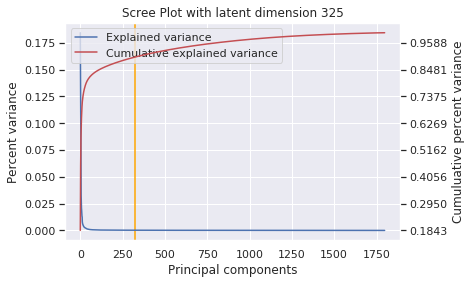

In [94]:
ScreePlot(completeMat)

In [90]:
totalDataDF.shape

(19625, 1799)

In [91]:
binaryPathwayDF = pd.read_csv('../data/pathways.tsv', sep='\t', header=0)
totalDataDF = totalDataDF.loc[np.concatenate([binaryPathwayDF['Genes'].values, phenotypes])]

/homes/gws/psturm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [92]:
totalDataDF.tail(10)

,488395315,496100277,496100278,496100279,496100281,496100283,496100284,496100285,496100287,496100288,...,1021204186,3451205016,4971205156,5371205166,1731204246,1321204196,4291205076,1081204186,651204176,2581204266
PCG,,,,,,,,,,,,,,,,,,,,,
ZXDC,0.339735,0.799306,0.916299,0.345511,0.307795,0.219958,0.276060,0.221786,0.398240,0.507288,...,0.392881,0.585724,0.376365,0.605298,0.507623,0.447824,0.544740,0.530185,0.153881,0.367297
ZYG11B,0.574833,0.053113,0.139220,0.699693,0.585744,0.553883,0.606556,0.747153,0.599618,0.519353,...,0.596673,0.211725,0.264016,0.199148,0.202338,0.394496,0.382368,0.344985,0.414471,0.429813
ZYX,0.647674,0.262791,0.408823,0.718260,0.510024,0.775412,0.735467,0.751700,0.822031,0.561199,...,0.589390,0.625693,0.660118,0.676924,0.636826,0.873388,0.792655,0.664260,0.808985,0.670901
ZZEF1,0.124157,0.621668,0.546131,0.261240,0.381972,0.332532,0.406236,0.383159,0.318522,0.417408,...,0.168095,0.418005,0.213792,0.209493,0.296624,0.345965,0.352991,0.243683,0.325451,0.177474
ZZZ3,0.283459,0.796310,0.773964,0.390281,0.140576,0.249999,0.377965,0.252026,0.300336,0.345826,...,0.491603,0.191183,0.294826,0.402578,0.357039,0.283476,0.267679,0.279757,0.463429,0.345128
BRAAK,0.500000,0.500000,1.000000,1.000000,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,...,0.333333,0.166667,0.833333,0.833333,0.833333,0.666667,0.500000,0.666667,0.500000,0.833333
CERAD,1.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.666667,...,0.666667,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.666667,0.000000,0.666667
PLAQUES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.193955,0.000000,0.424560,0.549603,0.569194,0.000000,0.207878,0.306999,0.000000,0.192465
ABETA_IHC,0.466675,0.038185,0.004278,0.010662,0.033745,0.040946,0.010449,0.355101,0.132327,0.035876,...,0.200114,0.022805,0.244584,0.479285,0.022235,0.000000,0.214177,0.502471,0.000000,0.309768


In [93]:
totalDataDF.to_csv('../data/totalDataDF.csv')

In [184]:
testDF = pd.read_csv('../data/totalDataDF.csv', header=0, index_col=0)